In [3]:
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog, TclError
import os

### Load Detections .csv from inference output

In [4]:
# here's the path to your inference detections
csv_path = "inference outputs/demo_video_20251201-153106.csv"

In [5]:
detections = pd.read_csv(csv_path)

# Try to recover the video path encoded in the detections file
video_path = None
if "video_path" in detections.columns:
    candidates = detections["video_path"].dropna().unique()
    if len(candidates) > 0:
        candidate_path = str(candidates[0]).strip()
        if candidate_path:
            video_path = candidate_path

# Quick existence check (fast fail for obviously-wrong paths which happen when you train on one computer and do this analysis on another)
if not video_path or os.path.exists(video_path) is False:  # fall back to asking for the path interactively
    root = None
    try:
        root = Tk()
        root.withdraw()  # Hide root window
        video_path = filedialog.askopenfilename(
            title="Select Video File",
            filetypes=[("Video files", "*.mp4 *.avi *.mov *.mkv"), ("All files", "*.*")]
        )
    except TclError as tk_err:
        print("Tkinter file dialog failed:", tk_err)
        video_path = input("Enter the full path to the video file: ").strip()
    finally:
        if root is not None:
            root.destroy()

if not video_path:
    raise RuntimeError("A video file must be provided to continue the analysis.")

print("Using video path:", video_path)
print("Using detections path:", csv_path)


Using video path: /Users/haggertydl/Desktop/SqueakPoseStudio/demo_video.mp4
Using detections path: inference outputs/demo_video_20251201-153106.csv


### Load video metadata and compute real world scale

In [6]:
# Load the video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError(f"Could not open video file: {video_path}")

# Get FPS and frame size automatically
FPS = cap.get(cv2.CAP_PROP_FPS)
image_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
image_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Loaded video properties: FPS = {FPS}, Width = {image_width}, Height = {image_height}")

# Grab the first frame for scale definition
ret, frame = cap.read()
cap.release()

if not ret:
    raise ValueError("Could not read first frame from video.")

# Set up global for point selection
points = []

def click_event(event, x, y, flags, param):
    global points
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 2:
        points.append((x, y))

# Show frame and get user clicks
frame_display = frame.copy()
cv2.imshow('Define Scale', frame_display)
cv2.setMouseCallback('Define Scale', click_event)

print("Click two points corresponding to a known distance, then press ESC.")

while True:
    frame_display = frame.copy()
    for pt in points:
        cv2.circle(frame_display, pt, 5, (0, 255, 0), -1)
    if len(points) == 2:
        cv2.line(frame_display, points[0], points[1], (255, 0, 0), 2)
    cv2.imshow('Define Scale', frame_display)

    key = cv2.waitKey(1) & 0xFF
    if len(points) == 2 or key == 27:
        break

cv2.destroyAllWindows()
cv2.waitKey(1)

if len(points) == 2:
    pixel_dist = np.linalg.norm(np.array(points[0]) - np.array(points[1]))
    print(f"Measured pixel distance: {pixel_dist:.2f} pixels")
    
    real_world_mm = float(input("Enter the real-world distance between points (in mm): "))
    pixels_per_mm = pixel_dist / real_world_mm
    mm_per_pixel = real_world_mm / pixel_dist

    print(f"Conversion: {mm_per_pixel:.6f} mm per pixel")
else:
    raise ValueError("Scale was not defined properly.")

Loaded video properties: FPS = 30.0, Width = 720, Height = 960
Click two points corresponding to a known distance, then press ESC.
Measured pixel distance: 324.02 pixels
Conversion: 0.694392 mm per pixel


### Now that we have some video metrics, lets smooth some detections

In [7]:
detections = detections.dropna(axis=1, how='all') #drop all the columns that just have NaNs
detections.columns

Index(['video_path', 'model_path', 'frame_index', 'time_seconds',
       'detections_in_frame', 'detection_index', 'class_id', 'class_name',
       'confidence', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'bbox_width',
       'bbox_height', 'bbox_area', 'bbox_center_x', 'bbox_center_y',
       'bbox_center_x_norm', 'bbox_center_y_norm', 'bbox_width_norm',
       'bbox_height_norm', 'image_width', 'image_height',
       'speed_preprocess_ms', 'speed_inference_ms', 'speed_postprocess_ms'],
      dtype='object')

In [9]:
from OneEuroFilter import OneEuroFilter
import math

# Ensure we have a valid sampling frequency from the loaded video
if "FPS" not in globals() or FPS is None or FPS <= 0:
    raise ValueError("Video FPS must be loaded before running the OneEuroFilter smoothing cell.")

freq = float(FPS)  # frame rate in Hz
min_cutoff = 1.0
beta = 0.0
d_cutoff = 1.0

# Create filter objects for cx and cy (timestamp-free calls rely on the configured freq)
euro_cx = OneEuroFilter(freq, min_cutoff, beta, d_cutoff)
euro_cy = OneEuroFilter(freq, min_cutoff, beta, d_cutoff)

# Sort detections by frame to keep temporal order, then smooth using constant sampling period
detections = detections.sort_values("frame_index").reset_index(drop=True)

filtered_cx = []
filtered_cy = []

for cx, cy in zip(detections["bbox_center_x"], detections["bbox_center_y"]):
    if pd.isna(cx) or pd.isna(cy):
        filtered_cx.append(math.nan)
        filtered_cy.append(math.nan)
        euro_cx.reset()
        euro_cy.reset()
        continue

    filtered_cx.append(euro_cx(cx))
    filtered_cy.append(euro_cy(cy))

detections["bbox_center_x_euro"] = filtered_cx
detections["bbox_center_y_euro"] = filtered_cy

detections

,video_path,model_path,frame_index,time_seconds,detections_in_frame,detection_index,class_id,class_name,confidence,bbox_x1,...,bbox_center_y_norm,bbox_width_norm,bbox_height_norm,image_width,image_height,speed_preprocess_ms,speed_inference_ms,speed_postprocess_ms,bbox_center_x_euro,bbox_center_y_euro
0,/Users/haggertydl/Desktop/SqueakPoseStudio/dem...,/Users/haggertydl/Desktop/SqueakPoseStudio/run...,0,0.000000,1,0,0.0,mouse,0.905979,366.075378,...,0.382319,0.102734,0.052353,720,960,4.414586,59.200846,10.216714,403.059631,367.026306
1,/Users/haggertydl/Desktop/SqueakPoseStudio/dem...,/Users/haggertydl/Desktop/SqueakPoseStudio/run...,1,0.033333,1,0,0.0,mouse,0.907860,367.891235,...,0.378874,0.108307,0.047458,720,960,4.414586,59.200846,10.216714,403.721488,366.453524
2,/Users/haggertydl/Desktop/SqueakPoseStudio/dem...,/Users/haggertydl/Desktop/SqueakPoseStudio/run...,2,0.066667,1,0,0.0,mouse,0.883732,370.656281,...,0.376102,0.109364,0.041466,720,960,4.414586,59.200846,10.216714,404.813488,365.519201
3,/Users/haggertydl/Desktop/SqueakPoseStudio/dem...,/Users/haggertydl/Desktop/SqueakPoseStudio/run...,3,0.100000,1,0,0.0,mouse,0.908234,373.972504,...,0.373390,0.114237,0.034885,720,960,4.414586,59.200846,10.216714,406.594432,364.295759
4,/Users/haggertydl/Desktop/SqueakPoseStudio/dem...,/Users/haggertydl/Desktop/SqueakPoseStudio/run...,4,0.133333,1,0,0.0,mouse,0.901659,377.640472,...,0.372924,0.117120,0.034394,720,960,4.414586,59.200846,10.216714,408.881871,363.206786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,/Users/haggertydl/Desktop/SqueakPoseStudio/dem...,/Users/haggertydl/Desktop/SqueakPoseStudio/run...,17996,599.866667,1,0,0.0,mouse,0.838766,420.172577,...,0.535544,0.048324,0.077358,720,960,1.076297,2.008086,4.530385,437.577264,519.773544
17997,/Users/haggertydl/Desktop/SqueakPoseStudio/dem...,/Users/haggertydl/Desktop/SqueakPoseStudio/run...,17997,599.900000,1,0,0.0,mouse,0.836077,420.829285,...,0.534693,0.047710,0.076853,720,960,1.076297,2.008086,4.530385,437.651305,518.653486
17998,/Users/haggertydl/Desktop/SqueakPoseStudio/dem...,/Users/haggertydl/Desktop/SqueakPoseStudio/run...,17998,599.933333,1,0,0.0,mouse,0.841879,420.981537,...,0.534687,0.047459,0.076361,720,960,1.076297,2.008086,4.530385,437.723262,517.726364
17999,/Users/haggertydl/Desktop/SqueakPoseStudio/dem...,/Users/haggertydl/Desktop/SqueakPoseStudio/run...,17999,599.966667,1,0,0.0,mouse,0.840610,421.344177,...,0.534874,0.047550,0.076312,720,960,1.076297,2.008086,4.530385,437.851202,516.990856


### Before you do anything else, lets check the confidence of the model by frames 

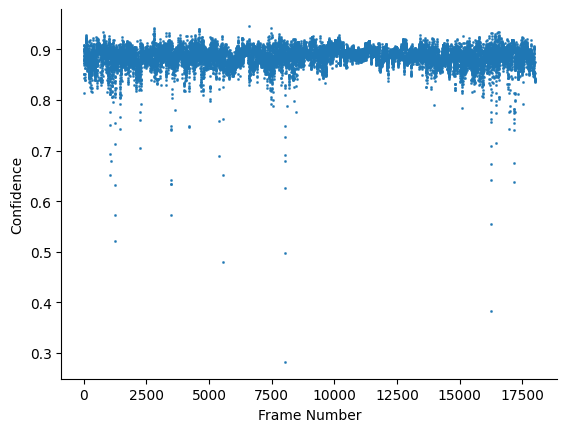

In [12]:
sns.scatterplot(data=detections, x='frame_index', y='confidence', edgecolor=None, s=3)

plt.ylabel('Confidence')
plt.xlabel('Frame Number')

sns.despine()

plt.show()

### Lets also check the metrics on the model speed

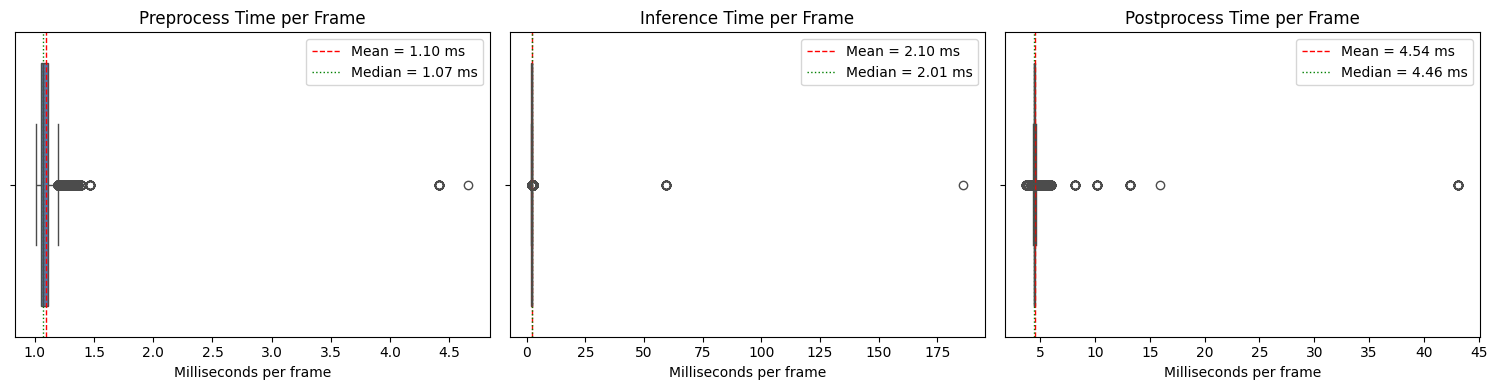

Total processing time by stage:
  Preprocess: 19.72 seconds (19717 ms)
  Inference: 37.73 seconds (37727 ms)
  Postprocess: 81.80 seconds (81802 ms)
Overall processing time: 139.25 seconds (139246 ms)
Video analysis summary:
  Total frames processed: 18001
  Video duration (real time): 600.03 seconds
  Effective processing FPS: 129.27 frames/sec
  Speedup vs real-time: 4.31x


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
speed_columns = [
    ("speed_preprocess_ms", "Preprocess"),
    ("speed_inference_ms", "Inference"),
    ("speed_postprocess_ms", "Postprocess")
]

stage_totals_ms = {}

for ax, (col, label) in zip(axes, speed_columns):
    sns.boxplot(data=detections, x=col, ax=ax, orient="h", color="#4c72b0")
    mean_val = detections[col].mean()
    median_val = detections[col].median()
    total_val = detections[col].sum()
    stage_totals_ms[label] = total_val
    ax.axvline(mean_val, color="red", linestyle="--", linewidth=1, label=f"Mean = {mean_val:.2f} ms")
    ax.axvline(median_val, color="green", linestyle=":", linewidth=1, label=f"Median = {median_val:.2f} ms")
    ax.set_title(f"{label} Time per Frame")
    ax.set_xlabel("Milliseconds per frame")
    ax.set_ylabel("")
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

total_processing_ms = sum(stage_totals_ms.values())
video_frames = len(detections)
video_duration_s = video_frames / FPS if FPS else float("nan")
processing_time_s = total_processing_ms / 1000
effective_fps = video_frames / processing_time_s if processing_time_s > 0 else float("nan")
speedup_vs_realtime = video_duration_s / processing_time_s if processing_time_s > 0 else float("nan")

print("Total processing time by stage:")
for stage, total in stage_totals_ms.items():
    print(f"  {stage}: {total/1000:.2f} seconds ({total:.0f} ms)")
print(f"Overall processing time: {processing_time_s:.2f} seconds ({total_processing_ms:.0f} ms)")

print("Video analysis summary:")
print(f"  Total frames processed: {video_frames}")
print(f"  Video duration (real time): {video_duration_s:.2f} seconds")
print(f"  Effective processing FPS: {effective_fps:.2f} frames/sec")
print(f"  Speedup vs real-time: {speedup_vs_realtime:.2f}x")


### New lets do some feature engineering

In [14]:
# Ensure one detection per frame in temporal order
detections = detections.sort_values(['frame_index', 'confidence'], ascending=[True, False])
detections = detections.drop_duplicates(subset='frame_index', keep='first').reset_index(drop=True)

# Differences in the smoothed center coordinates
detections['dx'] = detections['bbox_center_x_euro'].diff()
detections['dy'] = detections['bbox_center_y_euro'].diff()

# Frame and time deltas (default to video FPS when timestamps repeat or are missing)
frame_delta = detections['frame_index'].diff()
detections['dt_frames'] = frame_delta.fillna(1)
default_dt = 1.0 / FPS if FPS else np.nan
time_delta = detections['time_seconds'].diff()
dt_seconds = time_delta.where(time_delta > 0, detections['dt_frames'] * default_dt)
detections['dt_seconds'] = dt_seconds.fillna(detections['dt_frames'] * default_dt)

# Velocity, distance, and heading in pixels
detections['vx'] = detections['dx'] / detections['dt_seconds']
detections['vy'] = detections['dy'] / detections['dt_seconds']
detections['distance'] = np.sqrt(detections['dx']**2 + detections['dy']**2)
detections['speed_px_per_frame'] = detections['distance'] / detections['dt_frames']
detections['speed_px_per_sec'] = detections['distance'] / detections['dt_seconds']
detections['acceleration'] = detections['speed_px_per_sec'].diff() / detections['dt_seconds']
detections['heading'] = np.arctan2(detections['vy'], detections['vx'])

# Bounding-box descriptors (already in pixels)
detections['width'] = detections['bbox_width']
detections['height'] = detections['bbox_height']
detections['aspect_ratio'] = detections['width'] / detections['height']
detections['area'] = detections['width'] * detections['height']
detections['area_change'] = detections['area'].diff().fillna(0)
detections['aspect_change'] = detections['aspect_ratio'].diff().fillna(0)

# Metric conversions (fallback to NaN if scale not defined)
if 'mm_per_pixel' not in globals():
    mm_per_pixel = np.nan

detections['distance_mm'] = detections['distance'] * mm_per_pixel
detections['speed_mm_per_sec'] = detections['speed_px_per_sec'] * mm_per_pixel
detections['vx_mm'] = detections['vx'] * mm_per_pixel
detections['vy_mm'] = detections['vy'] * mm_per_pixel
detections['acceleration_mm_per_sec2'] = detections['acceleration'] * mm_per_pixel
detections['width_mm'] = detections['width'] * mm_per_pixel
detections['height_mm'] = detections['height'] * mm_per_pixel
detections['area_mm2'] = detections['area'] * (mm_per_pixel ** 2)

# Cumulative path length and heading in degrees
detections['cumulative_distance_mm'] = detections['distance_mm'].cumsum()
detections['heading_deg'] = (-np.degrees(detections['heading']) + 360) % 360

detections.head()


,video_path,model_path,frame_index,time_seconds,detections_in_frame,detection_index,class_id,class_name,confidence,bbox_x1,...,distance_mm,speed_mm_per_sec,vx_mm,vy_mm,acceleration_mm_per_sec2,width_mm,height_mm,area_mm2,cumulative_distance_mm,heading_deg
0,/Users/haggertydl/Desktop/SqueakPoseStudio/dem...,/Users/haggertydl/Desktop/SqueakPoseStudio/run...,0,0.000000,1,0,0.0,mouse,0.905979,366.075378,...,NaN,NaN,NaN,NaN,NaN,51.363083,34.899595,1792.550793,NaN,NaN
1,/Users/haggertydl/Desktop/SqueakPoseStudio/dem...,/Users/haggertydl/Desktop/SqueakPoseStudio/run...,1,0.033333,1,0,0.0,mouse,0.907860,367.891235,...,0.607795,18.233840,13.787635,-11.932058,NaN,54.149189,31.636328,1713.081497,0.607795,40.873480
2,/Users/haggertydl/Desktop/SqueakPoseStudio/dem...,/Users/haggertydl/Desktop/SqueakPoseStudio/run...,2,0.066667,1,0,0.0,mouse,0.883732,370.656281,...,0.997951,29.938517,22.748269,-19.463583,351.140315,54.677929,27.641733,1511.392722,1.605745,40.550535
3,/Users/haggertydl/Desktop/SqueakPoseStudio/dem...,/Users/haggertydl/Desktop/SqueakPoseStudio/run...,3,0.100000,1,0,0.0,mouse,0.908234,373.972504,...,1.500363,45.010884,37.100156,-25.486430,452.171007,57.114127,23.254657,1328.169429,3.106108,34.487620
4,/Users/haggertydl/Desktop/SqueakPoseStudio/dem...,/Users/haggertydl/Desktop/SqueakPoseStudio/run...,4,0.133333,1,0,0.0,mouse,0.901659,377.640472,...,1.759189,52.775657,47.651354,-22.685203,232.943194,58.555401,22.927826,1342.548026,4.865297,25.457544


### Distance Traveled

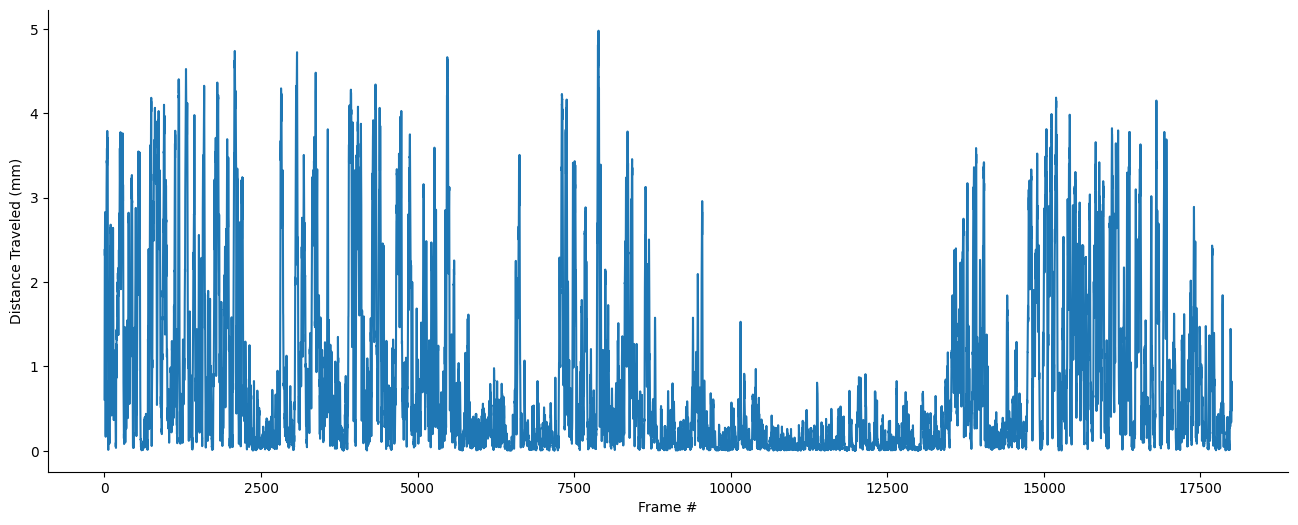

Total distance traveled: 15300.55 mm
Total distance traveled: 15.30 meters


In [23]:
plt.figure(figsize=(16, 6))
sns.lineplot(data = detections, x = 'frame_index', y = 'distance_mm')
plt.ylabel('Distance Traveled (mm)')
plt.xlabel('Frame #')
sns.despine()
plt.show()

# Total distance traveled
total_distance_mm = detections['distance_mm'].sum()
print(f"Total distance traveled: {total_distance_mm:.2f} mm")

total_distance_m = total_distance_mm/1000
print(f"Total distance traveled: {total_distance_m:.2f} meters")

### Plot velocity components and speed 

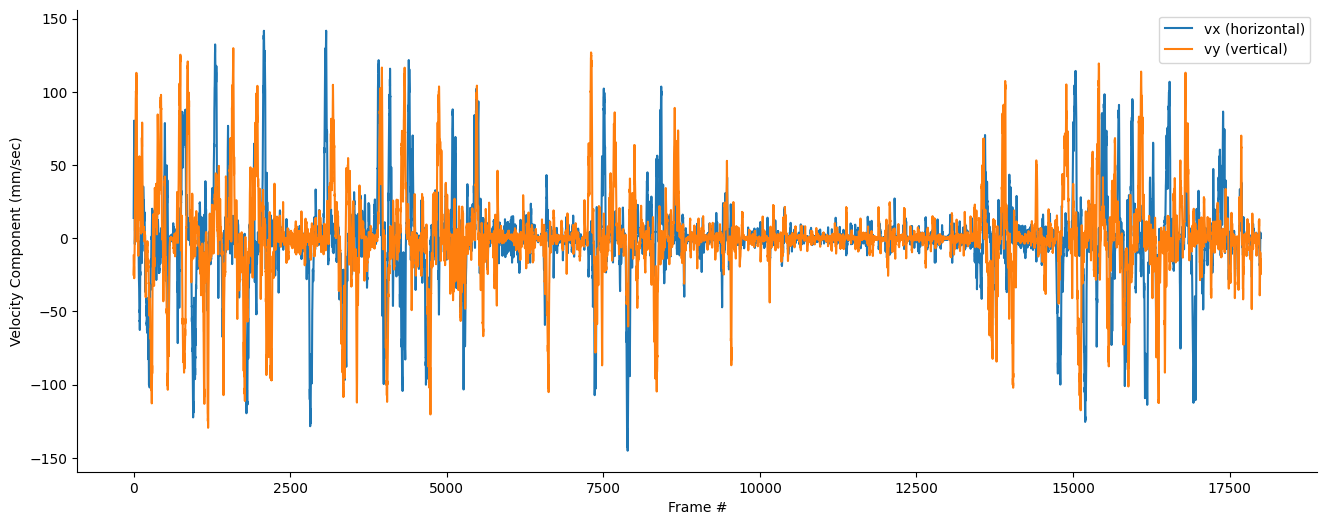

In [17]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=detections, x='frame_index', y='vx_mm', label='vx (horizontal)')
sns.lineplot(data=detections, x='frame_index', y='vy_mm', label='vy (vertical)')
plt.xlabel('Frame #')
plt.ylabel('Velocity Component (mm/sec)')
sns.despine()
plt.legend()
plt.show()

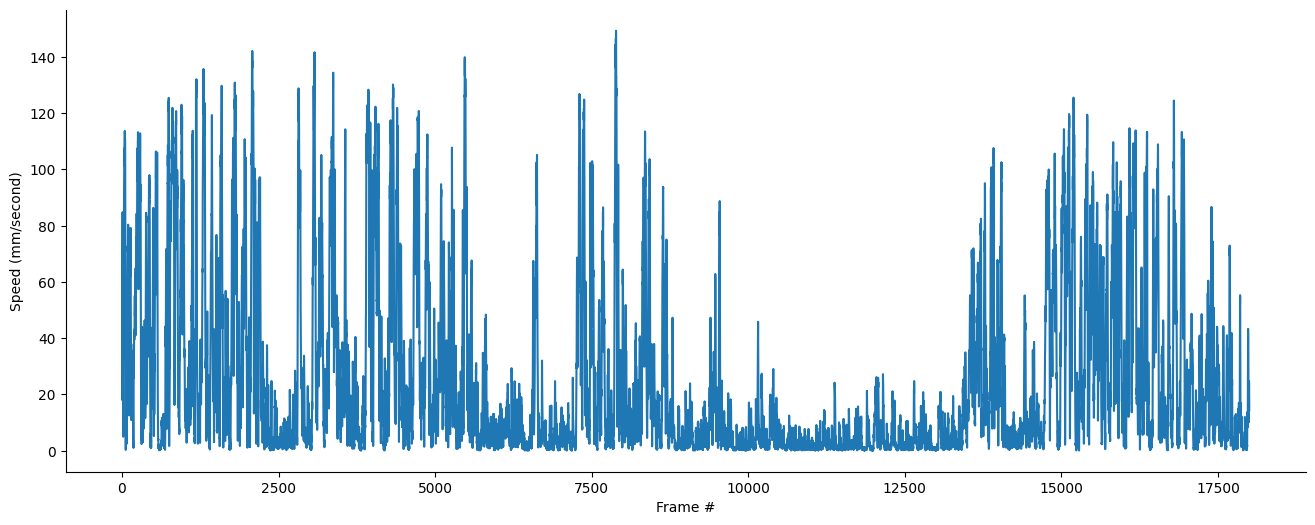

Average speed: 25.52 mm/second


In [22]:
plt.figure(figsize=(16, 6))
sns.lineplot(data = detections, x = 'frame_index', y = 'speed_mm_per_sec')
plt.ylabel('Speed (mm/second)')
plt.xlabel('Frame #')
sns.despine()
plt.show()

average_speed = detections['speed_mm_per_sec'].mean()
print(f"Average speed: {average_speed:.2f} mm/second")


### Plot Acceleration

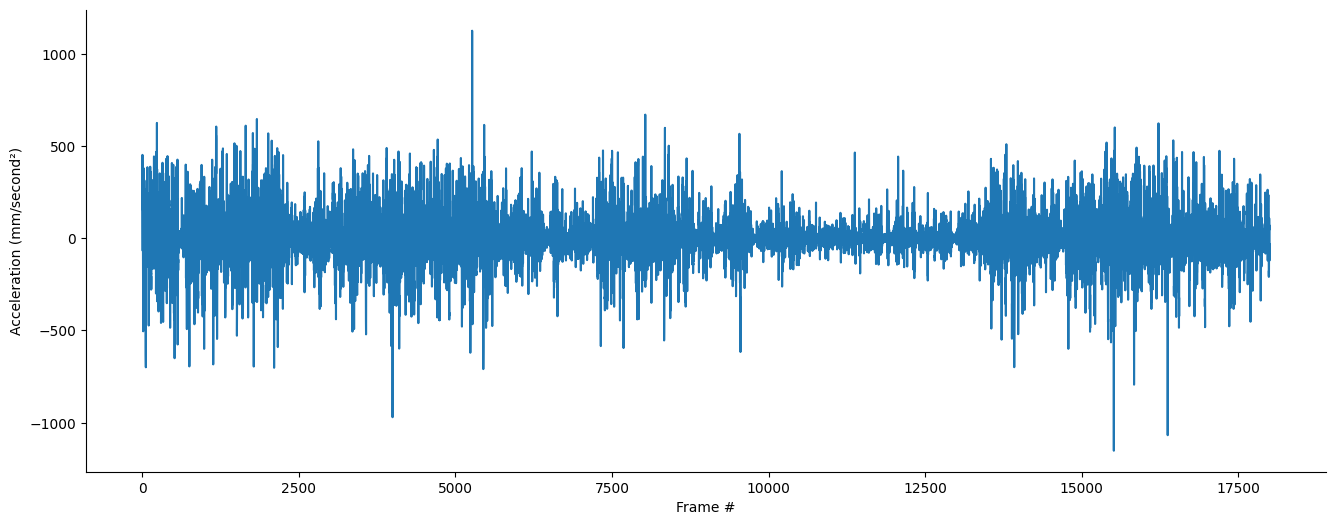

Average acceleration: 0.06 mm/second²


In [21]:
plt.figure(figsize=(16, 6))
sns.lineplot(data = detections, x = 'frame_index', y = 'acceleration_mm_per_sec2')
plt.ylabel('Acceleration (mm/second²)')
plt.xlabel('Frame #')
sns.despine()
plt.show()

average_accel = detections['acceleration_mm_per_sec2'].mean()
print(f"Average acceleration: {average_accel:.2f} mm/second²")

#### Compute heading (direction of velocity vectors across the whole task)

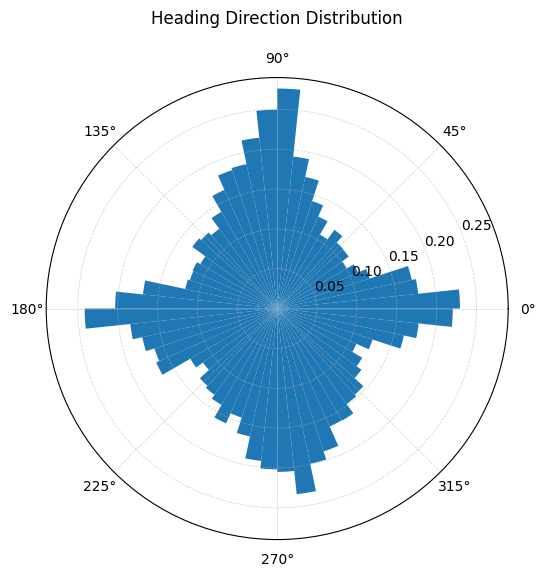

In [24]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

# Plot a polar histogram of heading angles
ax.hist(detections['heading'], bins=60, density=True)

ax.set_theta_zero_location('E')  # 0 at the top
ax.set_theta_direction(1)       # clockwise
ax.set_title('Heading Direction Distribution', y=1.1)

# Add grid for readability
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

plt.show()

### Plot trajectories

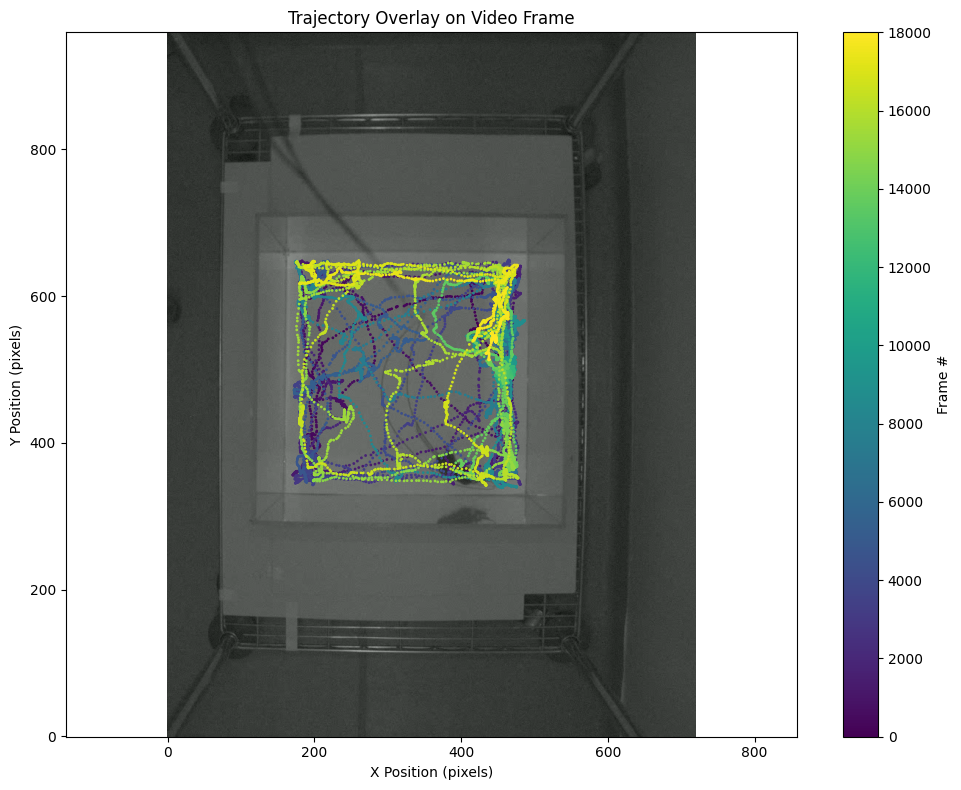

In [25]:
# Load the first frame from video
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

if not ret:
    raise ValueError("Failed to load frame from video")

# Convert BGR (OpenCV) to RGB for matplotlib
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Plot the background and trajectory
plt.figure(figsize=(10, 8))
plt.imshow(frame_rgb)
plt.scatter(detections['bbox_center_x'], detections['bbox_center_y'], c=detections['frame_index'], cmap='viridis', s=1)

plt.title('Trajectory Overlay on Video Frame')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')
plt.axis('equal')
plt.gca().invert_yaxis()  # OpenCV origin is top-left
plt.colorbar(label='Frame #')

plt.tight_layout()
plt.show()

### Plot Heatmaps

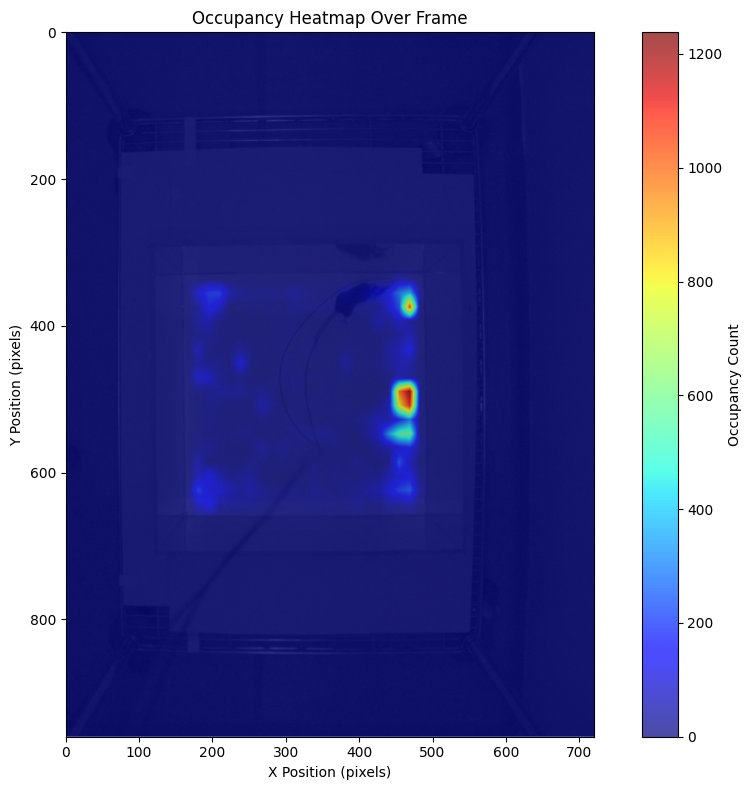

In [26]:
# Step 1: Load background frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

if not ret:
    raise ValueError("Failed to read a frame from video.")

# Convert to RGB for matplotlib display
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame_height, frame_width = frame.shape[:2]

# Step 2: Create 2D histogram of occupancy
heatmap, xedges, yedges = np.histogram2d(detections['bbox_center_x_euro'], detections['bbox_center_y_euro'], bins=50, range=[[0, frame_width], [0, frame_height]])

# Transpose to match image orientation
heatmap = heatmap.T

# Step 3: Plot the frame and overlay heatmap
plt.figure(figsize=(10, 8))
plt.imshow(frame_rgb)  # Background frame
plt.imshow(
    heatmap,
    cmap='jet',
    alpha=0.7,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    origin='lower',
    interpolation='bilinear'
)

plt.title("Occupancy Heatmap Over Frame")
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.gca().invert_yaxis()  # Match OpenCV coordinate system
plt.colorbar(label="Occupancy Count")
plt.tight_layout()
plt.show()


### Region of Interest Toolset 

#### This takes into account order of operations!!! If you draw overlapping ROIs, (which is encouraged) the ROI assignment will be computed the first ROI you draw. For this - we drew center first and then edges overlapping, so the center will always take rank

In [29]:
import cv2
import numpy as np
from matplotlib.path import Path

# --- Step 1: Load first frame from video ---
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

if not ret:
    raise ValueError("Could not read a frame from the video.")

# --- Step 2: Initialize drawing environment ---
frame_overlay = frame.copy()
roi_defs = []
drawing = False
start_pt = (-1, -1)
current_pt = (-1, -1)

def draw_all_rois(img):
    for roi in roi_defs:
        pts = np.array(roi['points'], dtype=np.int32)
        cv2.polylines(img, [pts], isClosed=True, color=(255, 0, 0), thickness=2)
        cv2.putText(img, roi['name'], pts[0], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

def mouse_callback(event, x, y, flags, param):
    global start_pt, current_pt, drawing, frame_overlay

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start_pt = (x, y)
        current_pt = (x, y)

    elif event == cv2.EVENT_MOUSEMOVE and drawing:
        current_pt = (x, y)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        current_pt = (x, y)
        x1, y1 = start_pt
        x2, y2 = current_pt
        xmin, xmax = sorted([x1, x2])
        ymin, ymax = sorted([y1, y2])
        rect_pts = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]

        name = input("Enter a name for this ROI: ")
        roi_defs.append({
            'name': name,
            'points': rect_pts,
            'path': Path(rect_pts)
        })
        print(f"ROI '{name}' saved.")

        frame_overlay = frame.copy()
        draw_all_rois(frame_overlay)

# --- Step 3: Launch window for interactive drawing ---
cv2.namedWindow("Draw Rectangular ROIs")
cv2.setMouseCallback("Draw Rectangular ROIs", mouse_callback)

print("🖱 Click and drag to draw a rectangle ROI.\nPress ESC when done.")

while True:
    display_frame = frame_overlay.copy()
    if drawing:
        cv2.rectangle(display_frame, start_pt, current_pt, (0, 255, 0), 2)
    cv2.imshow("Draw Rectangular ROIs", display_frame)
    if cv2.waitKey(1) & 0xFF == 27:  # ESC
        break

cv2.destroyAllWindows()
_ = cv2.waitKey(1)


🖱 Click and drag to draw a rectangle ROI.
Press ESC when done.
ROI 'Center' saved.
ROI 'Edge' saved.


In [30]:
# Helper utilities for ROI analysis
from typing import Iterable

def _require_rois(rois: Iterable) -> None:
    if not rois:
        raise RuntimeError('No ROIs defined. Run the ROI drawing cell to create ROI polygons.')


def assign_roi_labels(df: pd.DataFrame, rois: Iterable, x_col: str = 'bbox_center_x_euro', y_col: str = 'bbox_center_y_euro') -> pd.Series:
    """Return an ROI label for each row using the provided polygons."""
    _require_rois(rois)

    def locate(row) -> str:
        x = row.get(x_col)
        y = row.get(y_col)
        if pd.isna(x) or pd.isna(y):
            return np.nan
        for roi in rois:
            if roi['path'].contains_point((x, y)):
                return roi['name']
        return np.nan

    return df.apply(locate, axis=1)

def require_roi_labels(df: pd.DataFrame) -> None:
    if 'roi_label' not in df.columns:
        raise RuntimeError('ROI labels are missing. Run the ROI assignment cell first.')


def summarize_roi_time(df: pd.DataFrame, fps: float) -> pd.Series:
    require_roi_labels(df)
    counts = df['roi_label'].value_counts()
    return (counts / fps).sort_values(ascending=False)


def roi_transition_matrix(df: pd.DataFrame) -> pd.DataFrame:
    require_roi_labels(df)
    sequence = df['roi_label']
    transitions = pd.DataFrame({'from': sequence.shift(1), 'to': sequence})
    transitions = transitions[transitions['from'] != transitions['to']]
    return transitions.value_counts().unstack(fill_value=0)


In [31]:
# Assign ROI labels to each detection using smoothed center coordinates
detections['roi_label'] = assign_roi_labels(detections, roi_defs)
display_cols = ['frame_index', 'time_seconds', 'bbox_center_x_euro', 'bbox_center_y_euro', 'roi_label']
detections[display_cols].head()


,frame_index,time_seconds,bbox_center_x_euro,bbox_center_y_euro,roi_label
0,0,0.000000,403.059631,367.026306,Edge
1,1,0.033333,403.721488,366.453524,Edge
2,2,0.066667,404.813488,365.519201,Edge
3,3,0.100000,406.594432,364.295759,Edge
4,4,0.133333,408.881871,363.206786,Edge


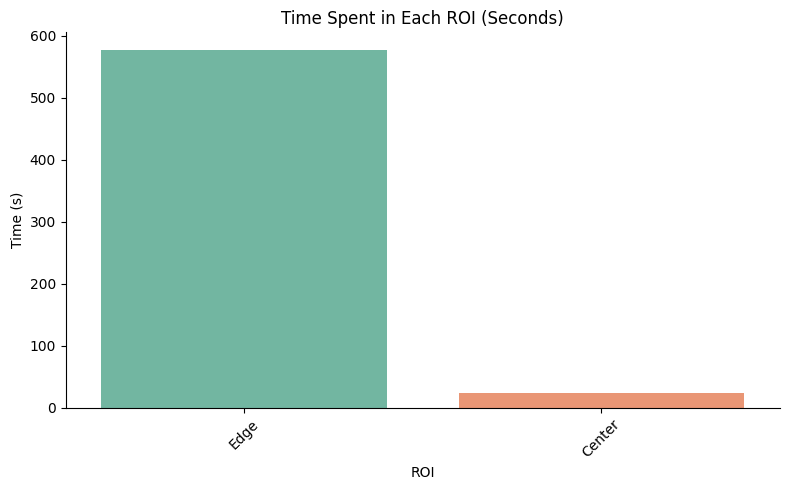

In [32]:
# Total time spent per ROI in seconds
roi_time_sec = summarize_roi_time(detections, FPS)

plt.figure(figsize=(8, 5))
sns.barplot(x=roi_time_sec.index, y=roi_time_sec.values, hue=roi_time_sec.index, palette='Set2', legend=False)
plt.title('Time Spent in Each ROI (Seconds)')
plt.ylabel('Time (s)')
plt.xlabel('ROI')
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.show()


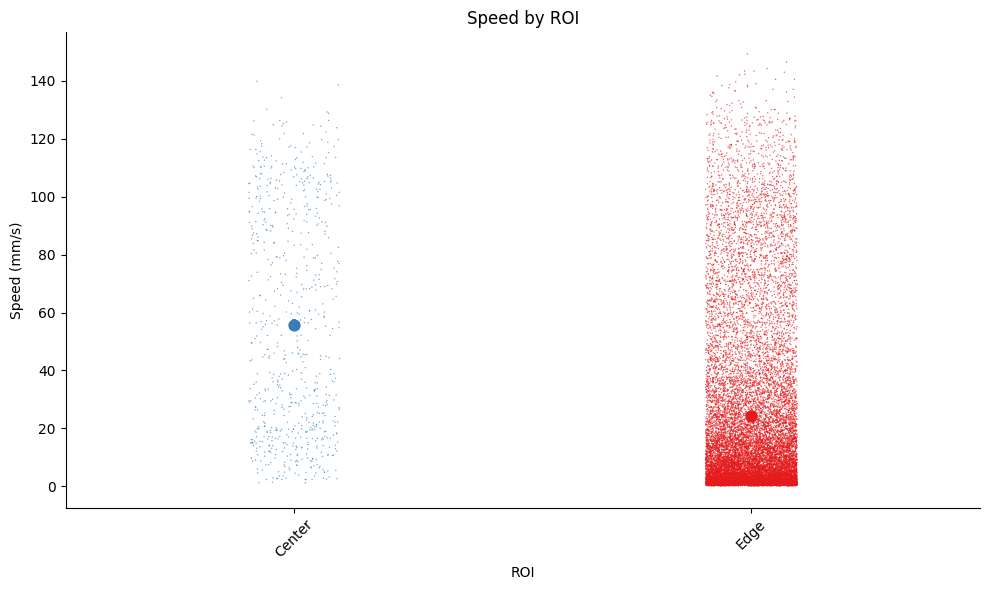

In [33]:
# Speed distribution by ROI
require_roi_labels(detections)
roi_speed_means = detections.groupby('roi_label')['speed_mm_per_sec'].mean().sort_values(ascending=False)
sorted_roi_labels = roi_speed_means.index.tolist()

plt.figure(figsize=(10, 6))
sns.pointplot(
    data=detections.dropna(subset=['roi_label']),
    x='roi_label',
    y='speed_mm_per_sec',
    order=sorted_roi_labels,
    linestyle='none',
    errorbar='se',
    hue='roi_label',
    palette='Set1'
)

sns.stripplot(
    data=detections.dropna(subset=['roi_label']),
    x='roi_label',
    y='speed_mm_per_sec',
    order=sorted_roi_labels,
    hue='roi_label',
    jitter=True,
    alpha=0.7,
    size=1,
    palette='Set1'
)

plt.title('Speed by ROI')
plt.xlabel('ROI')
plt.ylabel('Speed (mm/s)')
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.show()


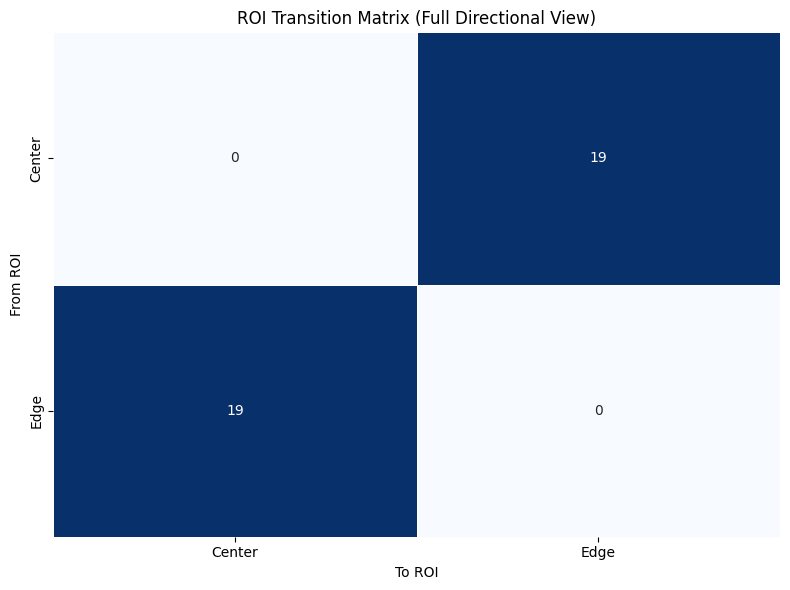

In [34]:
# ROI transition matrix
transition_counts = roi_transition_matrix(detections.dropna(subset=['roi_label']))

plt.figure(figsize=(8, 6))
sns.heatmap(
    transition_counts,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=0.5,
    cbar=False
)
plt.title('ROI Transition Matrix (Full Directional View)')
plt.xlabel('To ROI')
plt.ylabel('From ROI')
plt.tight_layout()
plt.show()


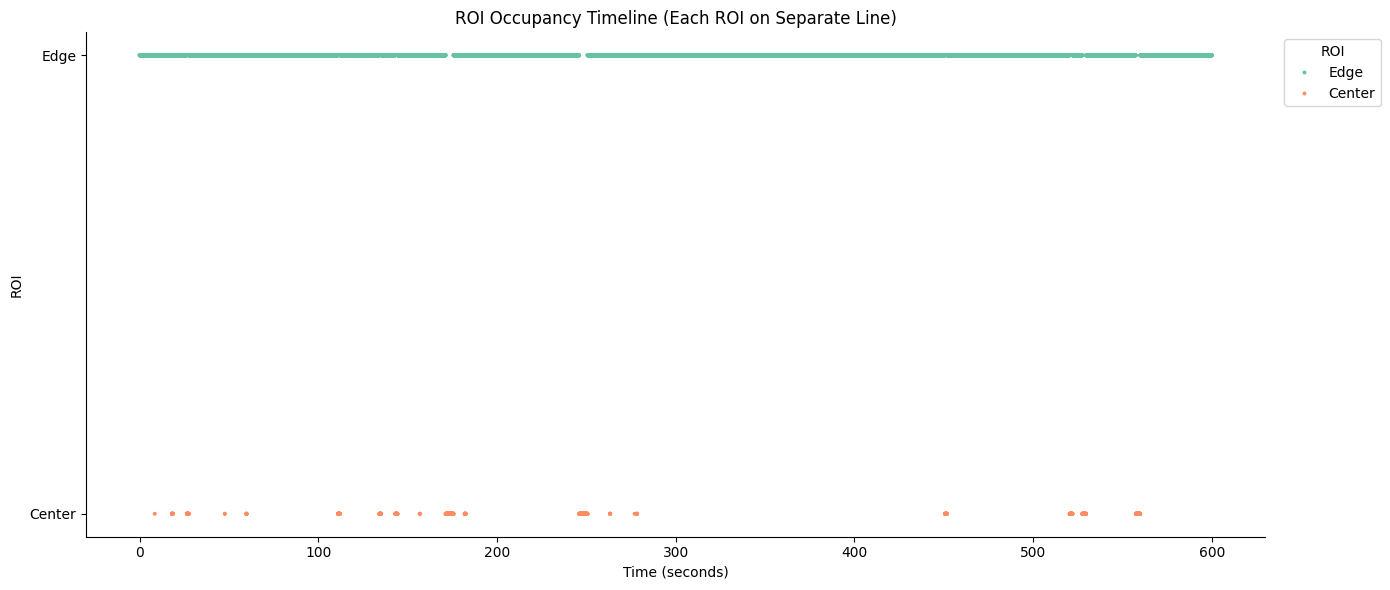

In [35]:
# ROI occupancy timeline
require_roi_labels(detections)
filtered = detections.dropna(subset=['roi_label'])
unique_rois = sorted(filtered['roi_label'].unique())
roi_to_y = {roi: i for i, roi in enumerate(unique_rois)}

filtered = filtered.assign(roi_y=filtered['roi_label'].map(roi_to_y))

plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=filtered,
    x='time_seconds',
    y='roi_y',
    hue='roi_label',
    palette='Set2',
    s=8,
    linewidth=0
)

plt.yticks(ticks=list(roi_to_y.values()), labels=list(roi_to_y.keys()))
plt.xlabel('Time (seconds)')
plt.ylabel('ROI')
plt.title('ROI Occupancy Timeline (Each ROI on Separate Line)')
plt.legend(title='ROI', bbox_to_anchor=(1.01, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()


### Make an annotated Video with annotation overlays

In [ ]:
# Render an annotated video using the smoothed detections dataframe
if 'roi_label' not in detections.columns:
    print('ROI labels not found; annotations will omit ROI text.')

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError("Cannot open video")

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('annotated_output.mp4', fourcc, fps if fps > 0 else FPS, (width, height))

frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame_idx >= len(detections):
        break

    row = detections.iloc[frame_idx]
    draw_annotations = True

    bbox_vals = [row.get('bbox_x1'), row.get('bbox_y1'), row.get('bbox_x2'), row.get('bbox_y2')]
    if any(pd.isna(v) for v in bbox_vals):
        draw_annotations = False
    else:
        x1, y1, x2, y2 = [int(round(v)) for v in bbox_vals]

    cx = row.get('bbox_center_x')
    cy = row.get('bbox_center_y')
    if pd.isna(cx) or pd.isna(cy):
        cx = row.get('bbox_center_x')
        cy = row.get('bbox_center_y')
    center_point = None if pd.isna(cx) or pd.isna(cy) else (int(round(cx)), int(round(cy)))

    text = f"Frame: {int(row['frame_index'])}"
    if not pd.isna(row.get('cumulative_distance_mm')):
        text += f" | Distance: {row['cumulative_distance_mm']:.1f} mm"

    speed_val = row.get('speed_mm_per_sec')
    heading_val = row.get('heading_deg')
    roi_label = row.get('roi_label') if 'roi_label' in detections.columns else None
    text2_parts = []
    if not pd.isna(speed_val):
        text2_parts.append(f"Speed: {speed_val:.1f} mm/s")
    if not pd.isna(heading_val):
        text2_parts.append(f"Heading: {heading_val:.0f} Degrees")
    if roi_label is not None and not pd.isna(roi_label):
        text2_parts.append(f"ROI: {roi_label}")
    text2 = " | ".join(text2_parts)

    if draw_annotations:
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        if center_point:
            cv2.circle(frame, center_point, 4, (0, 0, 255), -1)
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        if text2:
            cv2.putText(frame, text2, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    out.write(frame)
    frame_idx += 1

cap.release()
out.release()

### HDBSCAN + UMAP

In [37]:
detections.columns

Index(['video_path', 'model_path', 'frame_index', 'time_seconds',
       'detections_in_frame', 'detection_index', 'class_id', 'class_name',
       'confidence', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'bbox_width',
       'bbox_height', 'bbox_area', 'bbox_center_x', 'bbox_center_y',
       'bbox_center_x_norm', 'bbox_center_y_norm', 'bbox_width_norm',
       'bbox_height_norm', 'image_width', 'image_height',
       'speed_preprocess_ms', 'speed_inference_ms', 'speed_postprocess_ms',
       'bbox_center_x_euro', 'bbox_center_y_euro', 'dx', 'dy', 'dt_frames',
       'dt_seconds', 'vx', 'vy', 'distance', 'speed_px_per_frame',
       'speed_px_per_sec', 'acceleration', 'heading', 'width', 'height',
       'aspect_ratio', 'area', 'area_change', 'aspect_change', 'distance_mm',
       'speed_mm_per_sec', 'vx_mm', 'vy_mm', 'acceleration_mm_per_sec2',
       'width_mm', 'height_mm', 'area_mm2', 'cumulative_distance_mm',
       'heading_deg', 'roi_label'],
      dtype='object')

/Users/haggertydl/Desktop/SqueakPoseStudio/.venv/lib/python3.12/site-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/Users/haggertydl/Desktop/SqueakPoseStudio/.venv/lib/python3.12/site-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/Users/haggertydl/Desktop/SqueakPoseStudio/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Using 30 frames (~1.0 s) rolling window for temporal features.
Rows after 1 s window: 17898


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/haggertydl/Desktop/SqueakPoseStudio/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/haggertydl/Desktop/SqueakPoseStudio/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


behavior_cluster
-1.0      791
 0.0      111
 1.0      112
 2.0      214
 3.0      710
 4.0    15960
 NaN      103
Name: count, dtype: int64


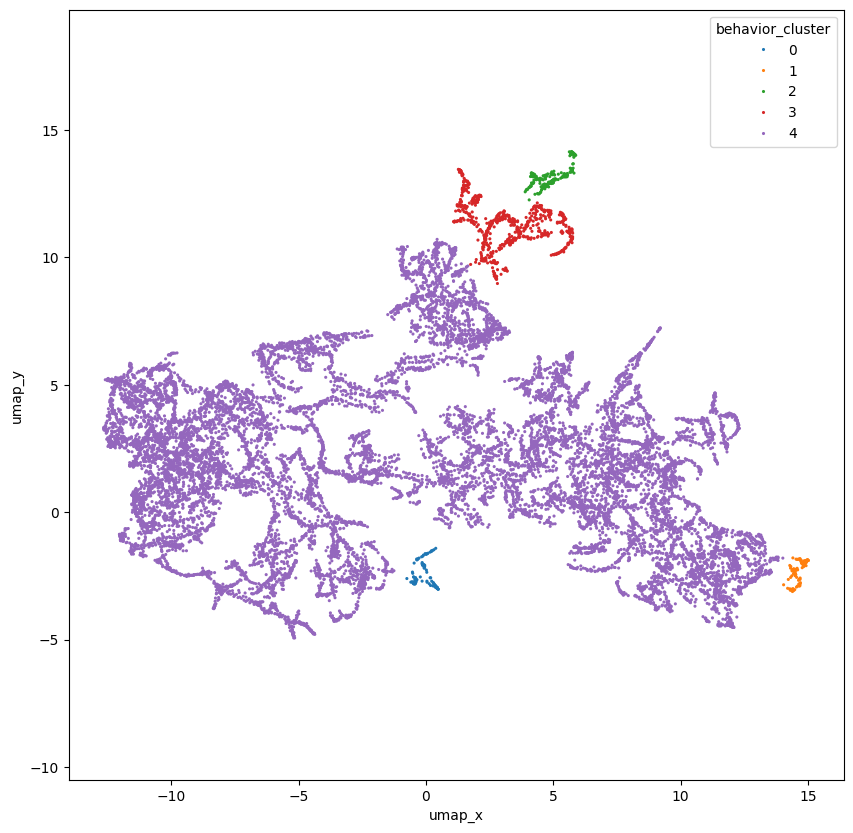

In [43]:
import os
os.environ.setdefault('NUMBA_CACHE_DIR', './numba_cache')  # set before first import

from sklearn.preprocessing import StandardScaler
import umap
import hdbscan

feature_cols = [
    'bbox_center_x', 'bbox_center_y',
    'speed_mm_per_sec', 'vx_mm', 'vy_mm',
    'acceleration_mm_per_sec2', 'distance_mm',
    'width_mm', 'height_mm',
    'aspect_ratio', 'area_mm2', 'heading_deg',
]

if 'FPS' in globals() and FPS and float(FPS) > 0:
    fps_estimate = float(FPS)
else:
    dt = detections['time_seconds'].diff().median() if 'time_seconds' in detections else None
    fps_estimate = 1.0 / dt if dt and dt > 0 else 30.0
window_frames = max(int(round(fps_estimate)), 1)
print(f'Using {window_frames} frames (~1.0 s) rolling window for temporal features.')

clean_features = (
    detections[feature_cols]
    .replace([np.inf, -np.inf], np.nan)
)

rolled_features = (
    clean_features
    .rolling(window=window_frames, min_periods=window_frames, center=True)
    .agg(['mean', 'std'])
)

rolled_features.columns = [
    f"{col}_{stat}_1s" for col, stat in rolled_features.columns
]

behavior_df = rolled_features.dropna()
print(f'Rows after 1 s window: {len(behavior_df)}')

if behavior_df.empty:
    raise ValueError('Rolling-window feature table is empty; check for missing data or adjust window size.')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(behavior_df)

umap_params = dict(
    n_neighbors=50,
    min_dist=0.3,
    spread=1,
    metric='euclidean',
    random_state=42,
    n_components=2,
)

umap_model = umap.UMAP(**umap_params)
embedding = umap_model.fit_transform(X_scaled)


clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,            # smaller → finer clusters
    min_samples=10,                 # looser density threshold
    metric='euclidean',
    cluster_selection_epsilon=0.3,  # tolerance for cluster splitting
    cluster_selection_method='leaf',  # more granular clustering
)
cluster_labels = clusterer.fit_predict(embedding)

detections.loc[behavior_df.index, 'behavior_cluster'] = cluster_labels
detections.loc[behavior_df.index, 'umap_x'] = embedding[:, 0]
detections.loc[behavior_df.index, 'umap_y'] = embedding[:, 1]

print(detections['behavior_cluster'].value_counts(dropna=False).sort_index())

plot_df = (
    detections.loc[behavior_df.index]
    .dropna(subset=['behavior_cluster', 'umap_x', 'umap_y'])
    .loc[lambda df: df['behavior_cluster'] != -1]
    .assign(behavior_cluster=lambda df: df['behavior_cluster'].astype(int))
)

if plot_df.empty:
    raise ValueError('No clustered points available after excluding noise (-1).')

plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=plot_df,
    x='umap_x', y='umap_y',
    hue='behavior_cluster', palette='tab10',
    hue_order=sorted(plot_df['behavior_cluster'].unique()),
    s=5, linewidth=0,
)
plt.gca().set_aspect('equal', 'datalim')
plt.show()


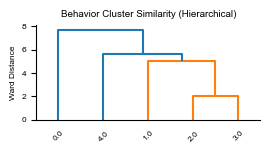

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# --- Filter out noise cluster (-1) ---
valid_clusters = detections.loc[detections['behavior_cluster'] != -1, 'behavior_cluster'].unique()
hue_order = sorted(valid_clusters)

# --- Build tab10 palette and mapping ---
base_tab10 = sns.color_palette('tab10', 10)
palette_cycled = [base_tab10[i % 10] for i in range(len(hue_order))]
cluster_color = {cl: mpl.colors.to_hex(palette_cycled[i]) for i, cl in enumerate(hue_order)}

# --- Compute cluster-level feature summary ---
feature_summary = (
    detections
    .query("behavior_cluster != -1")
    .groupby("behavior_cluster")[feature_cols]
    .agg(["mean", "median"])
    .sort_index()
)

feature_summary_flat = feature_summary.copy()
feature_summary_flat.columns = [f"{feat}_{stat}" for feat, stat in feature_summary_flat.columns]
cluster_means = feature_summary_flat[[c for c in feature_summary_flat.columns if c.endswith("_mean")]]

# --- Z-score normalize across clusters ---
cluster_means_z = (cluster_means - cluster_means.mean()) / cluster_means.std(ddof=0)

# --- Ward linkage ---
linkage_matrix = linkage(cluster_means_z, method="ward", metric="euclidean")

# --- Plot dendrogram ---
fig, ax = plt.subplots()
dendro = dendrogram(
    linkage_matrix,
    labels=cluster_means.index.astype(str),
    orientation="top",
    leaf_rotation=45,
    leaf_font_size=6,  # Adjust font size for compact figure
    ax=ax,
)

ax.set_title("Behavior Cluster Similarity (Hierarchical)", fontsize=7)
ax.set_ylabel("Ward Distance", fontsize=6)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
sns.despine()
plt.tight_layout(pad=0.2)

# --- Color the tick labels to match the UMAP colors ---
for tick in ax.get_xmajorticklabels():
    try:
        key = int(tick.get_text())
    except ValueError:
        key = tick.get_text()
    tick.set_color(cluster_color.get(key, "black"))


plt.show()

In [48]:
from pathlib import Path
import os
import numpy as np
import cv2

video_file = (video_path)
print(f"Using video file: {video_file}")

# Derive FPS if the earlier video-loading cell didn’t run
if "FPS" in globals() and FPS and float(FPS) > 0:
    fps = float(FPS)
else:
    dt = detections["time_seconds"].diff().median()
    fps = 1.0 / dt if dt and dt > 0 else 30.0
    print(f"FPS not found in globals; using inferred FPS={fps:.2f}")

frame_count = int(detections["frame_index"].max() + 1)
print(f"Detected {frame_count} frames in the detections table.")

output_dir = Path("cluster_clips")
output_dir.mkdir(exist_ok=True)

clip_length_sec = 2.0          # duration of each snippet
samples_per_cluster = 1         # how many snippets per cluster
pad_start_frames = 0  # show a little context before the representative frame

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
cap = cv2.VideoCapture(str(video_file))
if not cap.isOpened():
    raise ValueError(f"Failed to open video: {video_file}")

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_clip = int(clip_length_sec * fps)

clusters = (
    detections["behavior_cluster"]
    .dropna()
    .astype(int)
    .unique()
)
clusters = sorted(c for c in clusters if c != -1)  # skip noise label if present
print(f"Clusters to export: {clusters}")

for cluster_id in clusters:
    cluster_frames = (
        detections.loc[detections["behavior_cluster"] == cluster_id, "frame_index"]
        .dropna()
        .astype(int)
        .values
    )
    if len(cluster_frames) == 0:
        continue

    # Pick evenly spaced representatives within the cluster
    sample_indices = np.linspace(
        0,
        len(cluster_frames) - 1,
        num=min(samples_per_cluster, len(cluster_frames)),
        dtype=int,
    )

    for clip_idx, frame_idx in enumerate(cluster_frames[sample_indices], start=1):
        start_frame = max(int(frame_idx) - pad_start_frames, 0)
        end_frame = min(start_frame + frames_per_clip, frame_count)

        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        clip_name = output_dir / f"cluster_{cluster_id:02d}_sample_{clip_idx:02d}.mp4"
        writer = cv2.VideoWriter(str(clip_name), fourcc, fps, (width, height))
        written = 0

        while cap.get(cv2.CAP_PROP_POS_FRAMES) < end_frame:
            ret, frame = cap.read()
            if not ret:
                break
            writer.write(frame)
            written += 1

        writer.release()
        print(f"Saved {clip_name} ({written} frames from {start_frame} to {end_frame})")

cap.release()
print("Done.")


Using video file: /Users/haggertydl/Desktop/SqueakPoseStudio/demo_video.mp4
Detected 18001 frames in the detections table.
Clusters to export: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Saved cluster_clips/cluster_00_sample_01.mp4 (60 frames from 580 to 640)
Saved cluster_clips/cluster_01_sample_01.mp4 (60 frames from 10777 to 10837)
Saved cluster_clips/cluster_02_sample_01.mp4 (60 frames from 14109 to 14169)
Saved cluster_clips/cluster_03_sample_01.mp4 (60 frames from 2479 to 2539)
Saved cluster_clips/cluster_04_sample_01.mp4 (60 frames from 17 to 77)
Done.
